# Manua Loa $CO_2$ dataset with Recurrent NN Model


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# file path
file_path = "./data/CO2_MaunaLoa2025.csv"

# Load dataset
df = pd.read_csv(file_path)
print(df.head())

   month  decimal date  average  deseasonalized  ndays  sdev   unc
0      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4      7     1958.5370   315.87          315.20     -1 -9.99 -0.99


#### Detrend time series


In [4]:
co2_values = df['average'].values # get the co2 values

# detrend the time series
diff_co2 = co2_values[1:] - co2_values[:-1]

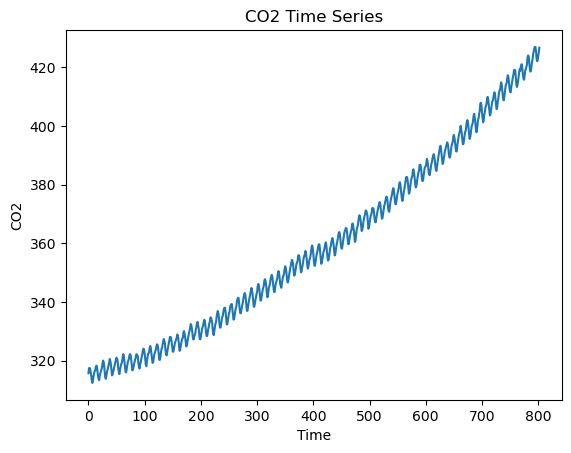

In [5]:
plt.plot(co2_values)
plt.title('CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.show()

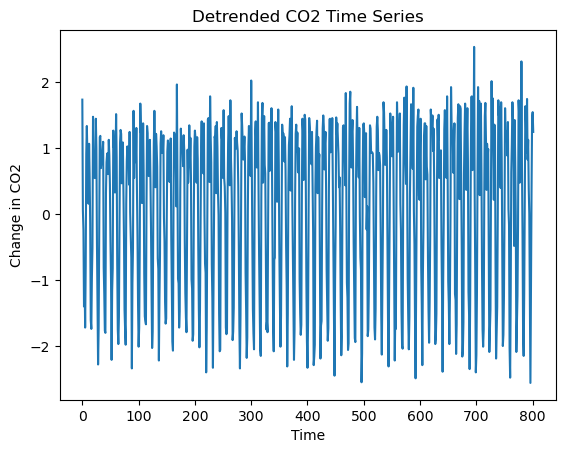

In [6]:
plt.plot(diff_co2)
plt.title('Detrended CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('Change in CO2')
plt.show()

In [7]:
# Prepare supervised learning dataset
def gen_data_splits(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

### Window size and label size


In [8]:

window_size = 24  # set window size

forecast = 12

X, y = gen_data_splits(diff_co2, window_size)

# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
X_train[0]

array([ 1.74,  0.06, -0.24, -1.4 , -0.94, -1.72, -0.79,  0.91,  1.34,
        0.91,  0.91,  0.16,  1.07,  0.57, -0.14, -1.61, -1.74, -0.96,
       -0.51,  1.48,  0.77,  0.85,  0.55,  0.6 ])

### Baseline Models


In [10]:
# Persistence Model
y_pred_persistence = X_test[:, -1]
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
print(f'Persistence Model MSE: {mse_persistence:.4f}')

Persistence Model MSE: 1.1717


In [11]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr:.4f}')

Linear Regression MSE: 0.1725


In [12]:
# MLP Model
inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_mlp = model.predict(X_test, verbose=0).flatten()
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f'MLP Model MSE: {mse_mlp:.4f}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769 (18.63 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

MLP Model MSE: 0.1974


In [13]:
len(y_test)

156

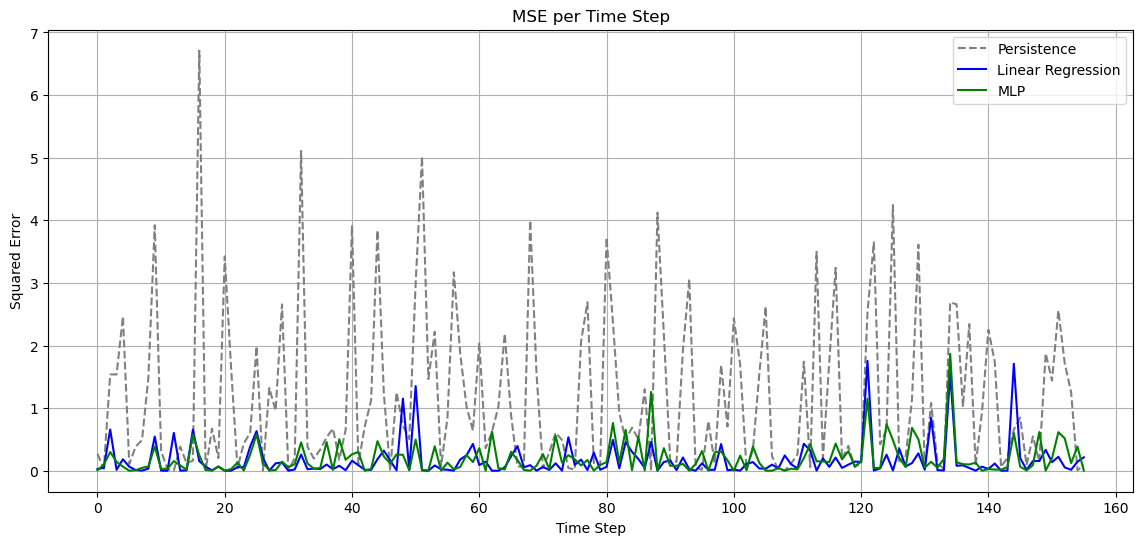

In [14]:
# Compute squared errors for each time step
mse_time_persistence = (y_test - y_pred_persistence) ** 2
mse_time_lr = (y_test - y_pred_lr) ** 2
mse_time_mlp = (y_test - y_pred_mlp) ** 2

# Plot MSE per Time Step
plt.figure(figsize=(14, 6))
time_steps = np.arange(len(y_test))

plt.plot(time_steps, mse_time_persistence, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps, mse_time_lr, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps, mse_time_mlp, label='MLP', linestyle='-', color='green')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE per Time Step')
plt.legend()
plt.grid(True)
plt.show()

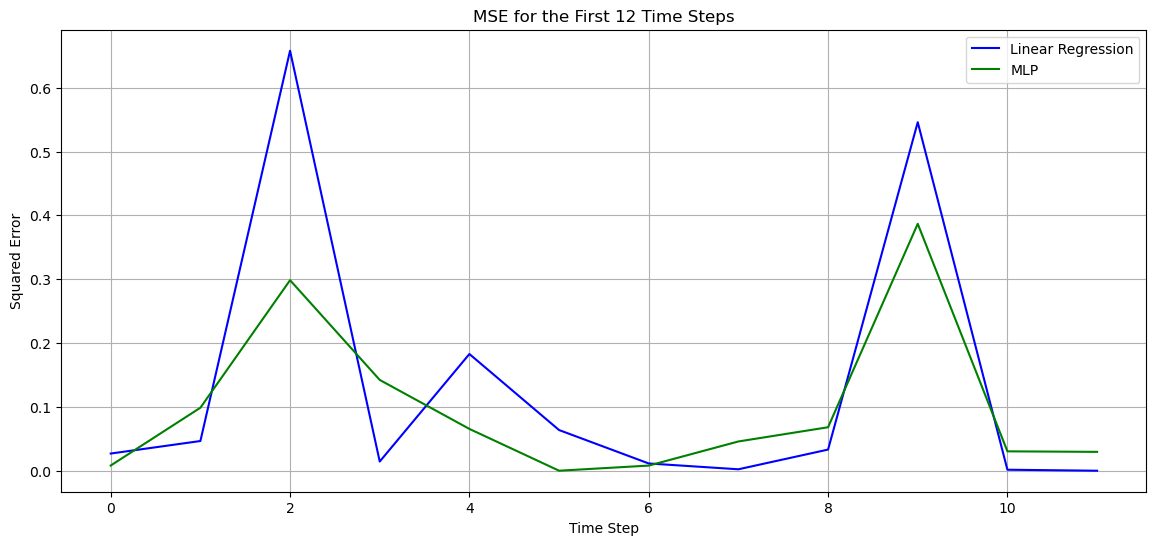

In [15]:
# Slice the last 12 time steps
time_steps_window = time_steps[:forecast]
mse_persistence_window = mse_time_persistence[:forecast]
mse_lr_window = mse_time_lr[:forecast]
mse_mlp_window = mse_time_mlp[:forecast]

# Plot the last 12 time steps
plt.figure(figsize=(14, 6))

# plt.plot(time_steps_window, mse_persistence_window, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps_window, mse_lr_window, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps_window, mse_mlp_window, label='MLP', linestyle='-', color='green')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE for the First 12 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

## Recurrent Neural Networks


#### LSTM dense encoder


In [16]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) # reshape to tensor object 
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # reshape to tensor object 

inp = tf.keras.layers.Input(shape=(window_size, 1))
b = tf.keras.layers.LSTM(16, return_sequences=True)(inp) # return sequences to pass the output to the next layer
b = tf.keras.layers.LSTM(16)(b)
out = tf.keras.layers.Dense(1)(b)
out = tf.keras.layers.Lambda(lambda x: x[:, -1])(out) # take the last output


model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None)                 │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_lstm_dense_encoder = model.predict(X_test_rnn, verbose=0).flatten()
mse_lstm_dense_encoder = mean_squared_error(y_test, y_pred_lstm_dense_encoder)
print(f'LSTM dense encoder Model MSE: {mse_lstm_dense_encoder:.4f}')

# Compute squared errors for each time step
mse_time_lstm_dense = (y_test - y_pred_lstm_dense_encoder) ** 2

# Slice the last 12 time steps
mse_lstm_dense_window = mse_time_lstm_dense[:forecast]

LSTM dense encoder Model MSE: 0.1841


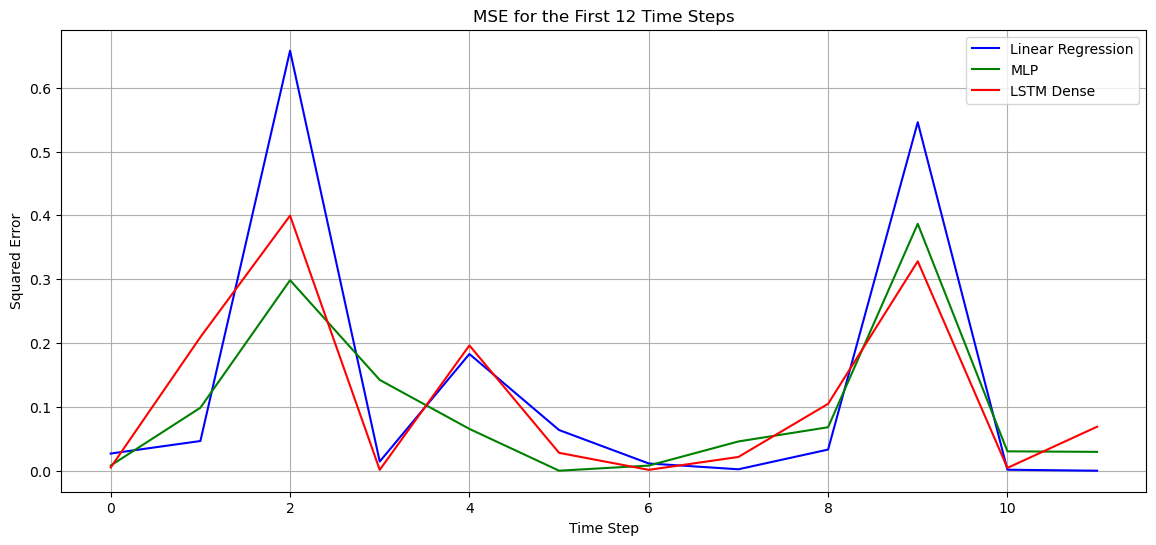

In [38]:
# Plot the last 12 time steps
plt.figure(figsize=(14, 6))

# plt.plot(time_steps_window, mse_persistence_window, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps_window, mse_lr_window, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps_window, mse_mlp_window, label='MLP', linestyle='-', color='green')
plt.plot(time_steps_window, mse_lstm_dense_window, label='LSTM Dense', linestyle='-', color='red')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE for the First 12 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM one-shot


In [48]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) # reshape to tensor object 
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # reshape to tensor object 

inp = tf.keras.layers.Input(shape=(window_size, 1))
b = tf.keras.layers.LSTM(16, return_sequences=True)(inp) # return sequences to pass the output to the next layer
b = tf.keras.layers.LSTM(16, return_sequences=True)(b)
b = tf.keras.layers.LSTM(1)(b)
out = tf.keras.layers.Lambda(lambda x: x[:, -forecast:])(b) # take the last forecast steps

model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 24, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 24, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 1)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,336 (13.03 KB)

 Trainable params: 3,336 (13.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_lstm_one_shot = model.predict(X_test_rnn, verbose=0).flatten()
mse_lstm_one_shot = mean_squared_error(y_test, y_pred_lstm_one_shot)
print(f'LSTM one-shot Model MSE: {mse_lstm_one_shot:.4f}')

# Compute squared errors for each time step
mse_time_lstm_one_shot = (y_test - y_pred_lstm_one_shot) ** 2

# Slice the last 12 time steps
mse_lstm_one_shot_window = mse_time_lstm_one_shot[:forecast]

LSTM one-shot Model MSE: 0.4330


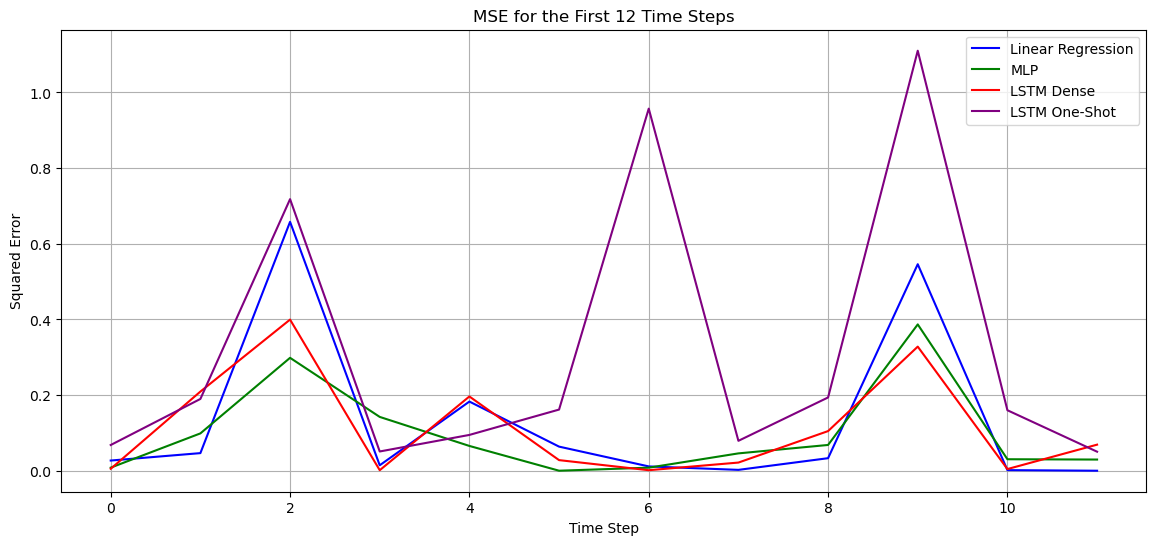

In [50]:
# Plot the last 12 time steps
plt.figure(figsize=(14, 6))

# plt.plot(time_steps_window, mse_persistence_window, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps_window, mse_lr_window, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps_window, mse_mlp_window, label='MLP', linestyle='-', color='green')
plt.plot(time_steps_window, mse_lstm_dense_window, label='LSTM Dense', linestyle='-', color='red')
plt.plot(time_steps_window, mse_lstm_one_shot_window, label='LSTM One-Shot', linestyle='-', color='purple')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE for the First 12 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM iterative


In [57]:
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) # reshape to tensor object 
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # reshape to tensor object 

inp = tf.keras.layers.Input(shape=(window_size, 1))
b = tf.keras.layers.LSTM(16, return_sequences=True)(inp) # return sequences to pass the output to the next layer
b = tf.keras.layers.LSTM(16, return_sequences=True)(b)
out = tf.keras.layers.Dense(1)(b)
out = tf.keras.layers.Lambda(lambda x: x[:, -1])(out) # take the last output

model = tf.keras.models.Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse')


predictions = []
current_input = X_test_rnn[0].reshape(1, window_size, 1)  # Reshape for batch dimension

for _ in range(forecast):
    pred = model.predict(current_input, verbose=0)  # Predict next step
    predictions.append(pred[0, 0])  # Extract scalar value

    # Update current_input for next prediction
    current_input = np.roll(current_input, shift=-1, axis=1)  # Shift the sequence
    current_input[0, -1, 0] = pred[0, 0]  # Replace last value with prediction

predictions = np.array(predictions).reshape(-1, 1)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 24, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 24, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24, 1)          │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_lstm_iterative = model.predict(X_test_rnn, verbose=0).flatten()
mse_lstm_iterative = mean_squared_error(y_test, y_pred_lstm_iterative)
print(f'LSTM iterative Model MSE: {mse_lstm_iterative:.4f}')

# Compute squared errors for each time step
mse_time_lstm_iterative = (y_test - y_pred_lstm_iterative) ** 2

# Slice the last 12 time steps
mse_lstm_iterative_window = mse_time_lstm_iterative[:forecast]

LSTM iterative Model MSE: 0.1975


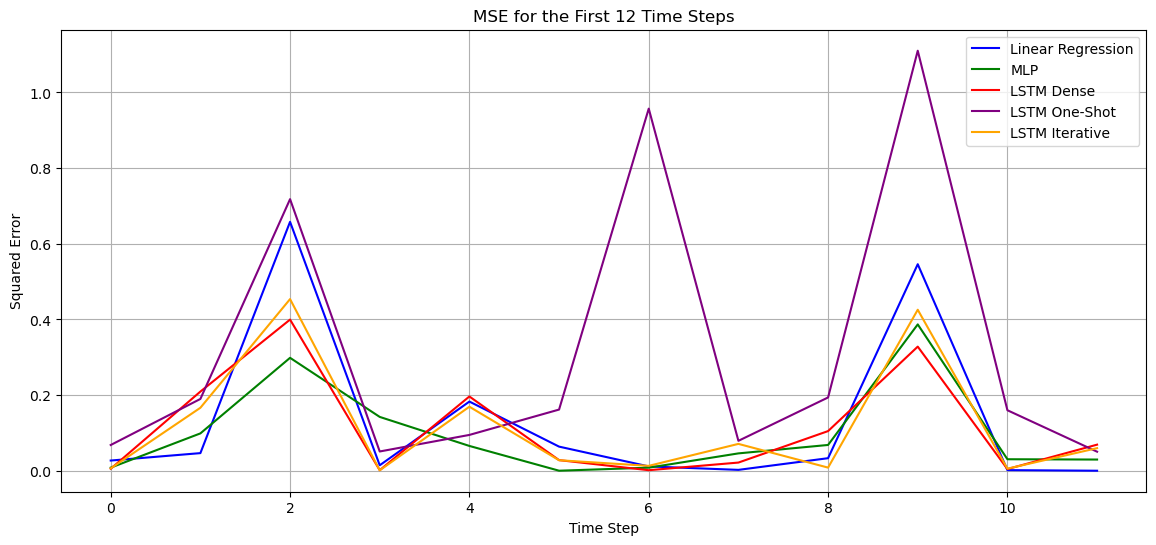

In [59]:
# Plot the last 12 time steps
plt.figure(figsize=(14, 6))

# plt.plot(time_steps_window, mse_persistence_window, label='Persistence', linestyle='--', color='gray')
plt.plot(time_steps_window, mse_lr_window, label='Linear Regression', linestyle='-', color='blue')
plt.plot(time_steps_window, mse_mlp_window, label='MLP', linestyle='-', color='green')
plt.plot(time_steps_window, mse_lstm_dense_window, label='LSTM Dense', linestyle='-', color='red')
plt.plot(time_steps_window, mse_lstm_one_shot_window, label='LSTM One-Shot', linestyle='-', color='purple')
plt.plot(time_steps_window, mse_lstm_iterative_window, label='LSTM Iterative', linestyle='-', color='orange')

plt.xlabel('Time Step')
plt.ylabel('Squared Error')
plt.title('MSE for the First 12 Time Steps')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM decoder-encoder


### WaveNet


In [ ]:
class WaveNetBlock(tf.keras.layers.Layer):
    def __init__(self, dilation_rate, filters, kernel_size, skip_channels, activation='relu'):
        super(WaveNetBlock, self).__init__()
        self.dilation_rate = dilation_rate
        self.filters = filters
        self.kernel_size = kernel_size
        self.skip_channels = skip_channels
        self.activation = activation

        # Layers
        self.conv = tf.keras.layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size,
                                    dilation_rate=self.dilation_rate, padding='causal', activation=None)
        self.activation_layer = tf.keras.layers.Activation(self.activation)
        self.skip_conv = tf.keras.layers.Conv1D(filters=self.skip_channels, kernel_size=1, activation=None)
        self.residual_conv = tf.keras.layers.Conv1D(filters=self.filters, kernel_size=1, activation=None)

    def call(self, inputs):
        # Main convolution (dilated convolution)
        x = self.conv(inputs)

        # Apply activation function
        x = self.activation_layer(x)

        # Skip connection (to add up later)
        skip = self.skip_conv(x)

        # Residual connection (add to input)
        residual = self.residual_conv(x)
        output = residual + inputs

        return output, skip